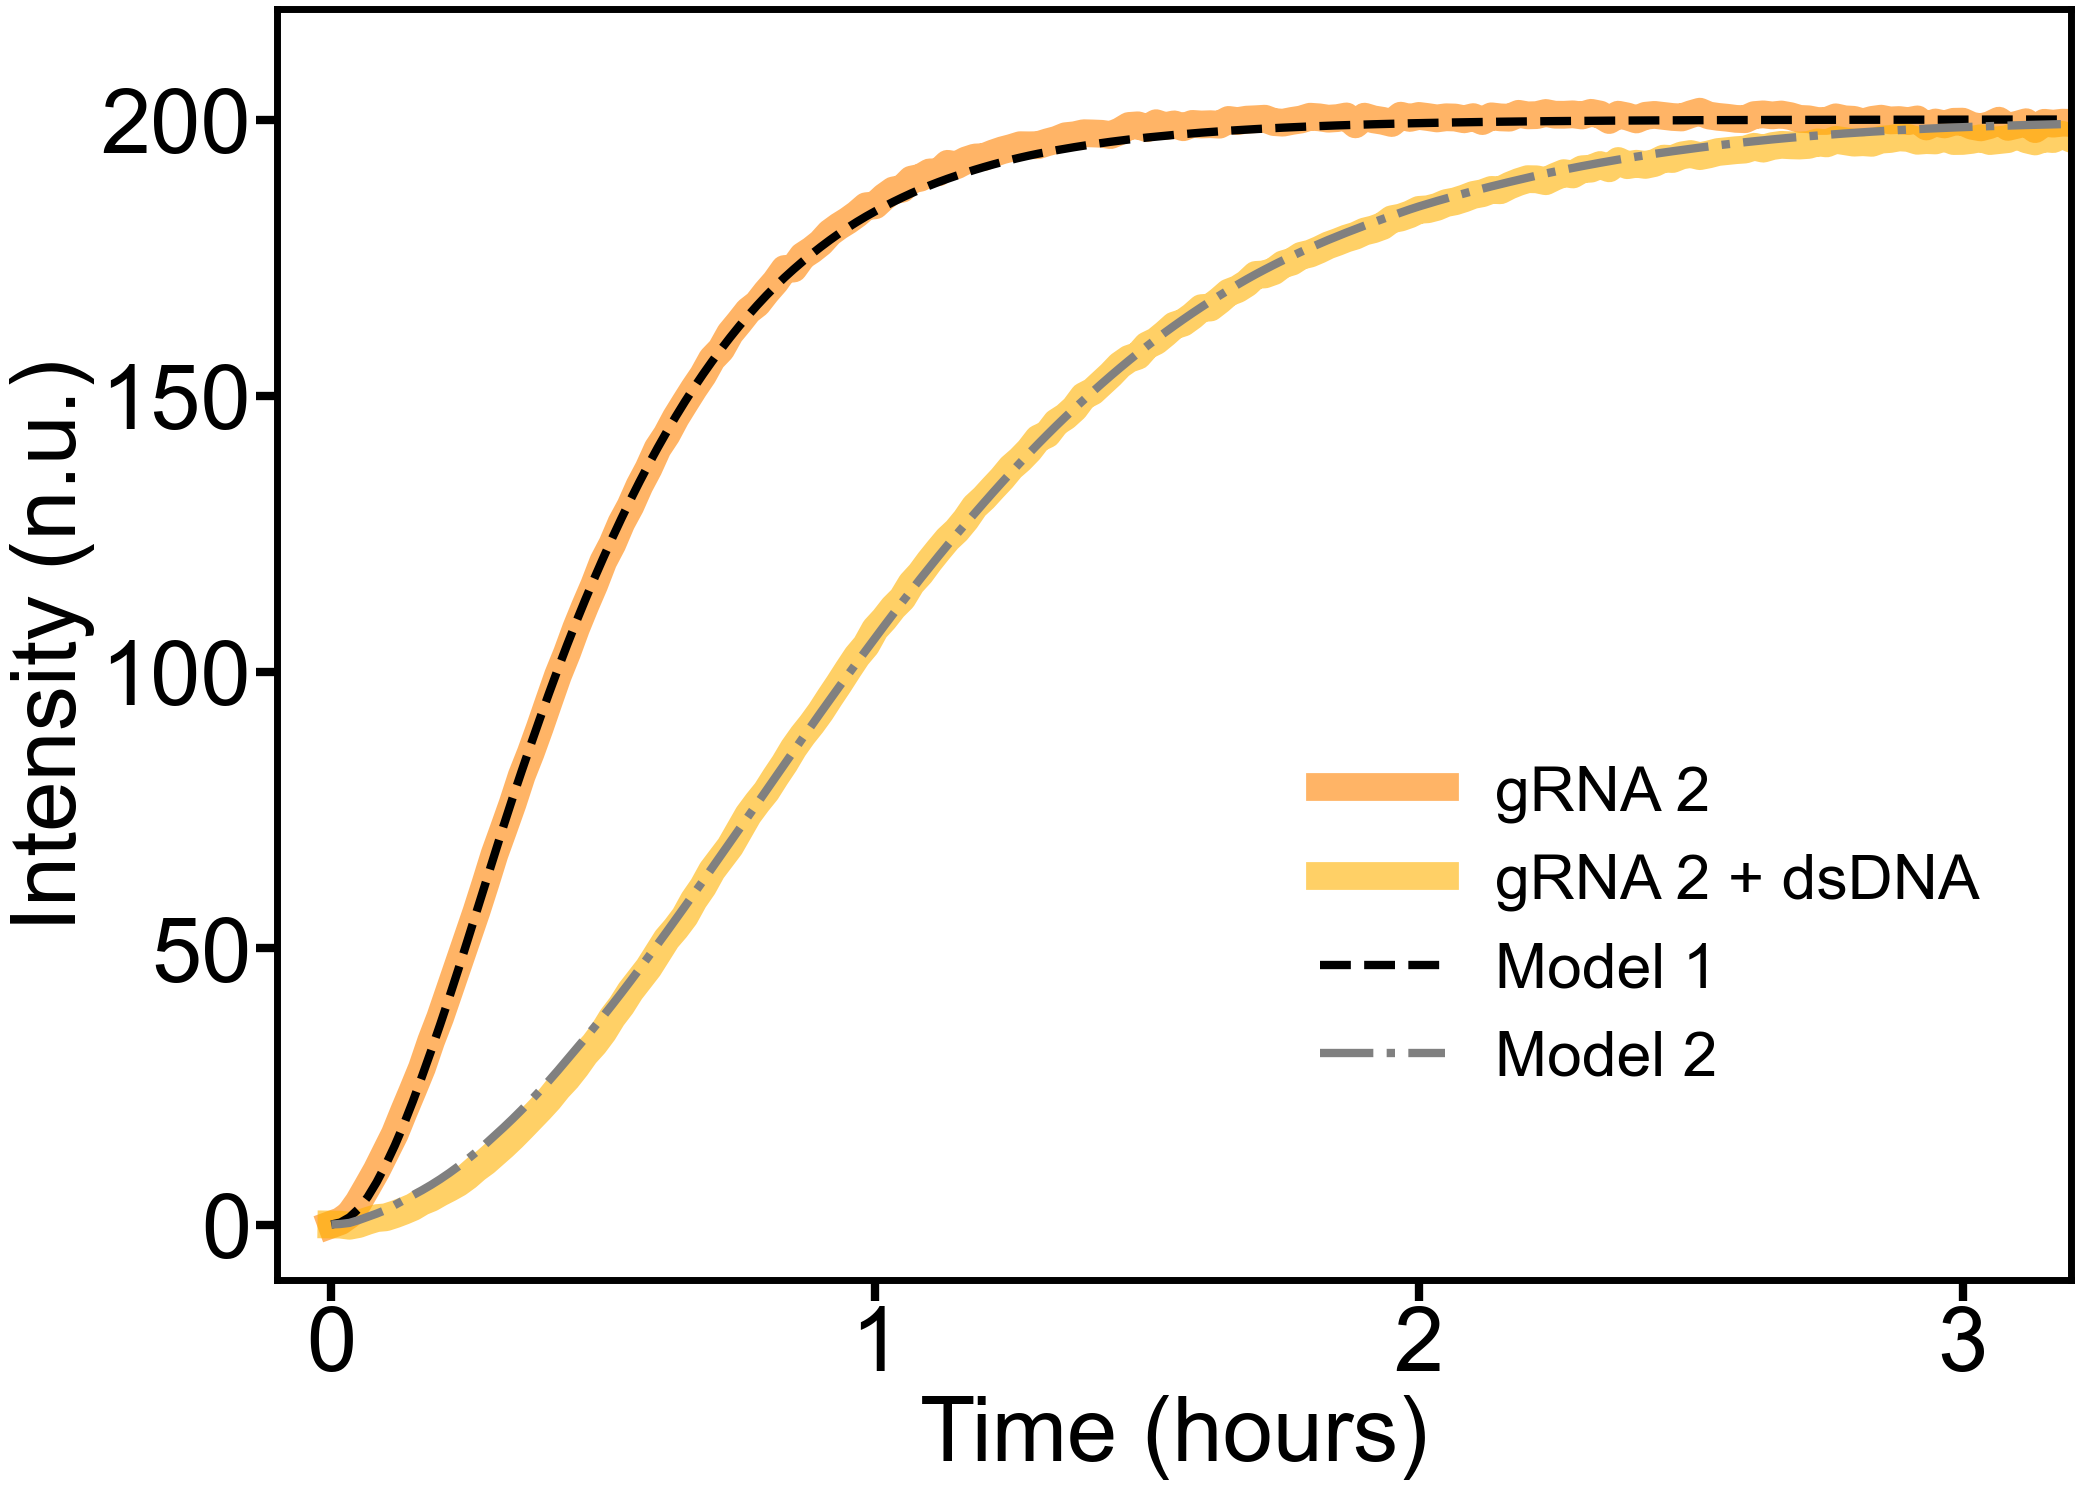

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


file_path = "Cas12gRNA2DNAdata.csv"  
df = pd.read_csv(file_path, delimiter=';', encoding='utf-8-sig', decimal=',')
df.columns = ['time_sec', 'F_signal_1', 'F_signal_2']
df['F_signal_1'] = pd.to_numeric(df['F_signal_1'], errors='coerce')
df['F_signal_2'] = pd.to_numeric(df['F_signal_2'], errors='coerce')
df = df.dropna()

t_max = 12000
df = df[df['time_sec'] <= t_max]
t_data = df['time_sec'].values
F_data_1 = df['F_signal_1'].values * 1e-9
F_data_2 = df['F_signal_2'].values * 1e-9

F0_1 = F_data_1[0]
F0_2 = F_data_2[0]
F_data_1 = 200e-9 * (F_data_1 - F0_1) / (200e-9 - F0_1)
F_data_2 = 200e-9 * (F_data_2 - F0_2) / (200e-9 - F0_2)

# === Initial conditions and parameters ===
C0 = 60e-9      # Cas12a
T0 = 6.7e-9     # Target DNA
B0 = 200e-9     # Background DNA
P0 = 200e-9     # Reporter
C_star0 = 0         # Active complex
CB0 = 0         # Cas12a bound to background
F0 = 0          # Cleaved reporter


k1 = 1.8e4
k2 = 1.4e5

k1_T = k1
k1_B = 1.1e6
k_cleave = k2  
koff_B = 0.026

# Model functions

def simulate_simple_model(t, k1, k2, C0, T0, C_star0, P0, F0):
    y0 = [C0, T0, C_star0, P0, F0]
    def odes(t, y):
        C, T, C_star, P, F = y
        dCdt = -k1 * C * T
        dTdt = -k1 * C * T
        dC_stardt = k1 * C * T
        dPdt = -k2 * C_star * P
        dFdt = k2 * C_star * P
        return [dCdt, dTdt, dC_stardt, dPdt, dFdt]
    sol = solve_ivp(odes, [t[0], t[-1]], y0=y0, t_eval=t, method='LSODA', rtol=1e-6, atol=1e-9)
    return sol.y[4]

def simulate_extended_model(t, koff_B, C0, T0, B0, P0, C_star0, CB0, F0):
    y0 = [C0, T0, B0, P0, C_star0, CB0, F0]
    def cas12a_kinetics(t, y):
        C, T, B, P, C_star, CB, F = y
        C, T, B, P, C_star, CB, F = map(lambda x: max(x, 0), [C, T, B, P, C_star, CB, F])
        dCdt = -k1_T * C * T - k1_B * C * B + koff_B * CB
        dTdt = -k1_T * C * T
        dBdt = -k1_B * C * B + koff_B * CB
        dPdt = -k2 * C_star * P
        dC_stardt = -dTdt 
        dCBdt = -dBdt
        dFdt = k2 * C_star * P
        return [dCdt, dTdt, dBdt, dPdt, dC_stardt, dCBdt, dFdt]
    sol = solve_ivp(cas12a_kinetics, [t[0], t[-1]], y0=y0, t_eval=t, method='LSODA', rtol=1e-6, atol=1e-9)
    return sol.y[6]


F_model_1 = simulate_simple_model(t_data, k1, k2, C0, T0, C_star0, P0, F0)
F_model_2 = simulate_extended_model(t_data, koff_B, C0, T0, B0, P0, C_star0, CB0, F0)


plt.rcParams['figure.figsize'] = 21, 15
plt.rcParams['xtick.labelsize'] = 65
plt.rcParams['ytick.labelsize'] = 65
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update({'figure.autolayout': False})
plt.rcParams['axes.linewidth'] = 5
plt.rcParams['font.family'] = 'Arial'

fig, ax = plt.subplots()

ax.plot(t_data / 3600, F_data_1 * 1e9, label="gRNA 2", linewidth=20, color="#ff8300", alpha=0.6)
ax.plot(t_data / 3600, F_data_2 * 1e9, label="gRNA 2 + dsDNA", linewidth=20, color="#ffb100", alpha=0.6)
ax.plot(t_data / 3600, F_model_1 * 1e9, '--', label="Model 1", linewidth=6, color="black")
ax.plot(t_data/ 3600 , F_model_2 * 1e9, '-.', label=f"Model 2", linewidth=6, color="gray")

ax.set_xlim([-0.1, 3.2])
ax.set_ylim([-10, 220])
ax.tick_params(axis='both', which='major', length=15, width=6)
ax.set_xlabel('Time (hours)', fontsize=65)
ax.set_ylabel('Intensity (n.u.)', fontsize=65)
ax.legend(loc='upper left', bbox_to_anchor=(0.55, 0.45), fontsize=45, frameon=False)

plt.tight_layout()
plt.savefig('Figure6.png', format='png', dpi=300)
plt.show()

In [22]:
from scipy.interpolate import interp1d

def find_half_time(t, F, threshold=100e-9):
    """Returns the time when F(t) reaches threshold"""
    if np.max(F) < threshold:
        return np.nan
    interp_fn = interp1d(F, t, bounds_error=False, assume_sorted=False)
    return float(interp_fn(threshold))

half_time_model_1 = find_half_time(t_data, F_model_1)
half_time_model_2 = find_half_time(t_data, F_model_2)
KD = koff_B/k1_B
ratio = half_time_model_2/half_time_model_1

print(f"Model 1 half-time: {half_time_model_1:.1f} s ({half_time_model_1 / 3600:.2f} h)")
print(f"Model 2 half-time: {half_time_model_2:.1f} s ({half_time_model_2 / 3600:.2f} h)")
print(f"Dissociation constant KD = {KD:.3e}")
print(f"ratio r = {ratio:.2f}")

Model 1 half-time: 1492.8 s (0.41 h)
Model 2 half-time: 3433.1 s (0.95 h)
Dissociation constant KD = 2.364e-08
ratio r = 2.30
